In [1]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Sequential, Model
from keras.models import model_from_json
from tensorflow import keras
from keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.compat.v1
from tensorflow.keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df1 = pd.read_pickle("../Data/returns.pkl").iloc[1:]

drop_columns = []
for col in df1.columns:
    if df1[col].isnull().all() == True:
        drop_columns.append(col)
        
df1.drop(columns=drop_columns, inplace=True)

In [4]:
def get_investable(t, n_rows):
    "Find stocks in investable universe at time t\
    (stocks in the S&P500 that have prices recorded for the last n_rows days)"
    
    df_investable = df1.copy(deep = True).sort_index(ascending = False)
    
    #add 1 date to get the test features in investable
    t = t + pd.DateOffset(1)
    
    #if t is now a non-trading day, advance until we reach a valid trading day
    while t not in df_investable.index:
        t = t + pd.DateOffset(1)
    
    t_index = df_investable.index.get_loc(t)
    
    #take n_rows worth of data upto time specified
    df_investable = df_investable.iloc[t_index + 1:t_index + n_rows + 1]
    
    #find all stocks that exist in the S&P at this time period
    investable_universe = []
    for col in df_investable.columns:
        if ~df_investable[col].iloc[:n_rows].isna().any():
            investable_universe.append(col)
        
    df_investable = df_investable[investable_universe]
    
    return df_investable

In [5]:
df1 = get_investable(pd.to_datetime('2018-05-11'),500)

In [6]:
tts = train_test_split(df1, test_size=0.2, shuffle=False)
train = tts[0]
test = tts[1]

In [7]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train)
test_set_scaled = sc.fit_transform(test)

In [8]:
# calculated log returns (i.e. the log of the difference between the price x+1 and price x)
# windows of train.shape[1] consecutive returns will be produced. 
# normalized with a MinMaxScaler to the range [0,1].

epochs = 250

class simple_autoencoder():
    
    def __init__(self):
        pass
    
    def reduced_dim(self):
        encoding_dim = 20
        window_length = training_set_scaled.shape[1]
        input_window = Input(shape=(window_length,))
        # encoded representation of the input
        encoded = Dense(encoding_dim, activation='tanh')(input_window) #tanh, linear, leakyrelu
        # model mapping an input to its encoded representation
        encoder = Model(input_window, encoded)
        return pd.DataFrame(encoder.predict(test_set_scaled)).head()

    def model(self,optimizer = "Adam", score = "acc", loss = "mean_squared_error", epochs = 250):
        encoding_dim = 20
        window_length = training_set_scaled.shape[1]
        # input placeholder
        input_window = Input(shape=(window_length,))
        # encoded representation of the input
        encoded = Dense(encoding_dim, activation='tanh')(input_window) #tanh, linear, leakyrelu
        # lossy reconstruction of the input
        decoded = Dense(window_length, activation='linear')(encoded) #linear
        # model mapping an input to its reconstruction
        simple_autoencoder = Model(input_window, decoded)
        simple_autoencoder.summary()
        sae = simple_autoencoder.compile(optimizer=optimizer, loss=loss, metrics=['acc','mae']) #MSE
        return simple_autoencoder

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, mode='auto', verbose = 1)
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5",save_best_only=True)


model = simple_autoencoder()
history = model.model().fit(training_set_scaled, training_set_scaled,
                    epochs=epochs,
                    batch_size=1024,
                    shuffle=True,
                    validation_split = 0.2,
                    callbacks = [monitor, checkpointer])       
#                   validation_data=(test_set_scaled, test_set_scaled))

decoded_stocks = simple_autoencoder().model().predict(test_set_scaled)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 644)]             0         
_________________________________________________________________
dense (Dense)                (None, 20)                12900     
_________________________________________________________________
dense_1 (Dense)              (None, 644)               13524     
Total params: 26,424
Trainable params: 26,424
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
1/1 [==============================] - 11s 11s/step - loss: 0.2875 - acc: 0.0000e+00 - mae: 0.5007 - val_loss: 0.2784 - val_acc: 0.0000e+00 - val_mae: 0.4940
Epoch 2/250
1/1 [==============================] - 0s 40ms/step - loss: 0.2735 - acc: 0.0031 - mae: 0.4909 - val_loss: 0.2689 - val_acc: 0.0000e+00 - val_mae: 0.4841
Epoch 3/250
1/1 [==============================] - 

1/1 [==============================] - 0s 48ms/step - loss: 0.0131 - acc: 0.0125 - mae: 0.0833 - val_loss: 0.0148 - val_acc: 0.0000e+00 - val_mae: 0.0873
Epoch 46/250
1/1 [==============================] - 0s 29ms/step - loss: 0.0128 - acc: 0.0125 - mae: 0.0820 - val_loss: 0.0145 - val_acc: 0.0000e+00 - val_mae: 0.0862
Epoch 47/250
1/1 [==============================] - 0s 26ms/step - loss: 0.0125 - acc: 0.0125 - mae: 0.0808 - val_loss: 0.0143 - val_acc: 0.0000e+00 - val_mae: 0.0852
Epoch 48/250
1/1 [==============================] - 0s 54ms/step - loss: 0.0122 - acc: 0.0125 - mae: 0.0797 - val_loss: 0.0140 - val_acc: 0.1250 - val_mae: 0.0842
Epoch 49/250
1/1 [==============================] - 0s 46ms/step - loss: 0.0120 - acc: 0.1187 - mae: 0.0787 - val_loss: 0.0138 - val_acc: 0.1500 - val_mae: 0.0833
Epoch 50/250
1/1 [==============================] - 0s 33ms/step - loss: 0.0117 - acc: 0.1750 - mae: 0.0778 - val_loss: 0.0136 - val_acc: 0.1500 - val_mae: 0.0825
Epoch 51/250
1/1 [=====

1/1 [==============================] - 0s 25ms/step - loss: 0.0098 - acc: 0.1844 - mae: 0.0682 - val_loss: 0.0119 - val_acc: 0.1500 - val_mae: 0.0739
Epoch 96/250
1/1 [==============================] - 0s 30ms/step - loss: 0.0098 - acc: 0.1844 - mae: 0.0682 - val_loss: 0.0119 - val_acc: 0.1500 - val_mae: 0.0738
Epoch 97/250
1/1 [==============================] - 0s 28ms/step - loss: 0.0098 - acc: 0.1844 - mae: 0.0682 - val_loss: 0.0119 - val_acc: 0.1500 - val_mae: 0.0738
Epoch 98/250
1/1 [==============================] - 0s 25ms/step - loss: 0.0098 - acc: 0.1844 - mae: 0.0681 - val_loss: 0.0119 - val_acc: 0.1500 - val_mae: 0.0738
Epoch 99/250
1/1 [==============================] - 0s 32ms/step - loss: 0.0098 - acc: 0.1813 - mae: 0.0681 - val_loss: 0.0119 - val_acc: 0.1500 - val_mae: 0.0738
Epoch 100/250
1/1 [==============================] - 0s 28ms/step - loss: 0.0098 - acc: 0.1813 - mae: 0.0681 - val_loss: 0.0119 - val_acc: 0.1500 - val_mae: 0.0738
Epoch 101/250
1/1 [===============

1/1 [==============================] - 0s 30ms/step - loss: 0.0093 - acc: 0.1750 - mae: 0.0664 - val_loss: 0.0117 - val_acc: 0.1500 - val_mae: 0.0726
Epoch 146/250
1/1 [==============================] - 0s 30ms/step - loss: 0.0093 - acc: 0.1750 - mae: 0.0664 - val_loss: 0.0116 - val_acc: 0.1500 - val_mae: 0.0726
Epoch 147/250
1/1 [==============================] - 0s 33ms/step - loss: 0.0093 - acc: 0.1750 - mae: 0.0663 - val_loss: 0.0116 - val_acc: 0.1500 - val_mae: 0.0726
Epoch 148/250
1/1 [==============================] - 0s 34ms/step - loss: 0.0093 - acc: 0.1750 - mae: 0.0663 - val_loss: 0.0116 - val_acc: 0.1500 - val_mae: 0.0725
Epoch 149/250
1/1 [==============================] - 0s 25ms/step - loss: 0.0093 - acc: 0.1750 - mae: 0.0662 - val_loss: 0.0116 - val_acc: 0.1500 - val_mae: 0.0725
Epoch 150/250
1/1 [==============================] - 0s 26ms/step - loss: 0.0093 - acc: 0.1750 - mae: 0.0662 - val_loss: 0.0116 - val_acc: 0.1500 - val_mae: 0.0725
Epoch 151/250
1/1 [===========

1/1 [==============================] - 0s 22ms/step - loss: 0.0088 - acc: 0.1750 - mae: 0.0641 - val_loss: 0.0112 - val_acc: 0.1500 - val_mae: 0.0709
Epoch 196/250
1/1 [==============================] - 0s 20ms/step - loss: 0.0088 - acc: 0.1750 - mae: 0.0641 - val_loss: 0.0112 - val_acc: 0.1500 - val_mae: 0.0709
Epoch 197/250
1/1 [==============================] - 0s 23ms/step - loss: 0.0087 - acc: 0.1750 - mae: 0.0641 - val_loss: 0.0112 - val_acc: 0.1500 - val_mae: 0.0708
Epoch 198/250
1/1 [==============================] - 0s 22ms/step - loss: 0.0087 - acc: 0.1750 - mae: 0.0640 - val_loss: 0.0112 - val_acc: 0.1500 - val_mae: 0.0708
Epoch 199/250
1/1 [==============================] - 0s 20ms/step - loss: 0.0087 - acc: 0.1750 - mae: 0.0640 - val_loss: 0.0112 - val_acc: 0.1500 - val_mae: 0.0708
Epoch 200/250
1/1 [==============================] - 0s 21ms/step - loss: 0.0087 - acc: 0.1750 - mae: 0.0640 - val_loss: 0.0112 - val_acc: 0.1500 - val_mae: 0.0708
Epoch 201/250
1/1 [===========

1/1 [==============================] - 0s 26ms/step - loss: 0.0085 - acc: 0.1750 - mae: 0.0631 - val_loss: 0.0110 - val_acc: 0.1500 - val_mae: 0.0699
Epoch 246/250
1/1 [==============================] - 0s 22ms/step - loss: 0.0085 - acc: 0.1750 - mae: 0.0631 - val_loss: 0.0110 - val_acc: 0.1500 - val_mae: 0.0699
Epoch 247/250
1/1 [==============================] - 0s 21ms/step - loss: 0.0085 - acc: 0.1750 - mae: 0.0631 - val_loss: 0.0110 - val_acc: 0.1500 - val_mae: 0.0699
Epoch 248/250
1/1 [==============================] - 0s 46ms/step - loss: 0.0085 - acc: 0.1750 - mae: 0.0631 - val_loss: 0.0110 - val_acc: 0.1500 - val_mae: 0.0699
Epoch 249/250
1/1 [==============================] - 0s 39ms/step - loss: 0.0085 - acc: 0.1750 - mae: 0.0631 - val_loss: 0.0110 - val_acc: 0.1500 - val_mae: 0.0699
Epoch 250/250
1/1 [==============================] - 0s 22ms/step - loss: 0.0085 - acc: 0.1750 - mae: 0.0631 - val_loss: 0.0110 - val_acc: 0.1500 - val_mae: 0.0699
Model: "model_1"
_____________

In [9]:
simple_autoencoder().reduced_dim()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.622507,0.407368,-0.214510,0.806359,0.487520,0.519140,0.658717,-0.061238,0.400183,-0.082774,-0.018668,0.477773,0.408408,-0.225123,-0.746708,-0.216064,0.514340,-0.219927,0.484705,0.739327
1,-0.665546,0.332077,0.306328,0.845157,0.378590,0.498875,0.787913,-0.097629,0.310637,0.109444,0.281932,-0.021151,0.600632,-0.095384,-0.797391,0.482128,0.595226,-0.268552,0.302145,0.791331
2,-0.626102,0.192291,0.366238,0.772201,0.527536,0.457795,0.799344,-0.286114,0.254085,-0.166339,0.422577,0.313438,0.684595,-0.085658,-0.773745,0.030570,0.324075,-0.544847,0.326352,0.835627
3,-0.629605,0.270956,0.066702,0.848207,0.414008,0.404725,0.706411,-0.456213,0.367470,-0.307985,0.075451,0.113194,0.717568,0.021446,-0.628271,0.075955,0.325393,-0.511374,0.504569,0.697474
4,-0.630929,0.530425,0.144248,0.856890,0.521062,0.379760,0.675277,-0.272479,0.402648,-0.057378,0.184452,0.217882,0.335407,0.046215,-0.723375,0.126813,0.527359,-0.443565,0.399089,0.710649


In [10]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 4, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 4, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")
    ax = plt.subplot(1, 4, 3)
    plt.plot(history.history["val_acc"])
    plt.title("Accuracy")
    ax = plt.subplot(1, 4, 4)
    plt.plot(history.history["val_mae"])
    plt.title("Mean Absolute Error")

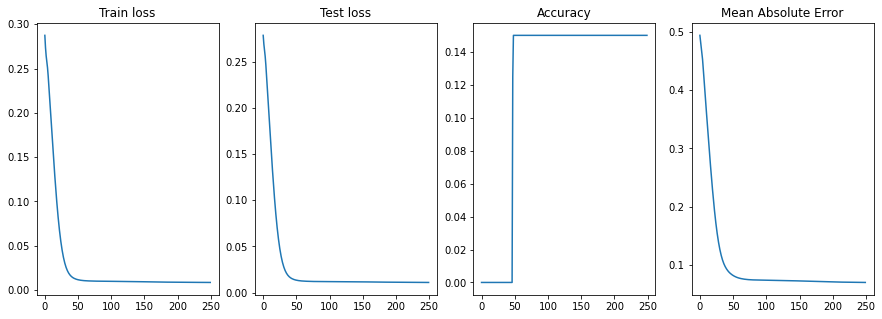

In [11]:
# Loss vs Epoch
plot_history(history)

## Hyperparameter Tuning

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

model_regressor = KerasRegressor(simple_autoencoder().model, verbose=1, batch_size=10, epochs=10)
#define the grid search parameters
#dimensions = []
#dropout = []
#batch_size = [10,20]
loss = ['mean_squared_error']
optimizer = ['Adam', 'SGD', 'RMSprop']
epochs = [10, 15]
scoring = ['acc']

param_grid = dict(optimizer=optimizer,score = scoring)

In [13]:
random_search = RandomizedSearchCV(estimator=model_regressor, param_distributions=param_grid, n_iter=100)
random_search.fit(training_set_scaled, training_set_scaled)

random_best_parameters = random_search.best_params_
random_best_accuracy = random_search.best_score_

/Users/anjalichauhan/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 3 is smaller than n_iter=100. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 644)]             0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                12900     
_________________________________________________________________
dense_6 (Dense)              (None, 644)               13524     
Total params: 26,424
Trainable params: 26,424
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 0.2143 - acc: 0.0042 - mae: 0.4084
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0198 - acc: 0.1338 - mae: 0.0984
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0095 - acc: 0.1838 - mae: 0.0677
Epoch 4/10
32/32 [==============================] - 0s 2ms/step 

32/32 [==============================] - 0s 1ms/step - loss: 0.2169 - acc: 0.0097 - mae: 0.4074 
Epoch 2/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0229 - acc: 0.0107 - mae: 0.1067
Epoch 3/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0108 - acc: 0.1258 - mae: 0.0722
Epoch 4/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0101 - acc: 0.1920 - mae: 0.0694
Epoch 5/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0100 - acc: 0.2126 - mae: 0.0689
Epoch 6/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0094 - acc: 0.1806 - mae: 0.0667
Epoch 7/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0093 - acc: 0.1913 - mae: 0.0665
Epoch 8/10
32/32 [==============================] - 0s 1ms/step - loss: 0.0088 - acc: 0.1742 - mae: 0.0641
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0089 - acc: 0.1853 - mae: 0.0652
Epoch 10/10
8/8 [==============================

32/32 [==============================] - 0s 2ms/step - loss: 0.2711 - acc: 0.0000e+00 - mae: 0.4868
Epoch 6/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2647 - acc: 0.0000e+00 - mae: 0.4814
Epoch 7/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2666 - acc: 0.0000e+00 - mae: 0.4820
Epoch 8/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2608 - acc: 0.0000e+00 - mae: 0.4762
Epoch 9/10
32/32 [==============================] - 0s 1ms/step - loss: 0.2579 - acc: 0.0000e+00 - mae: 0.4730
Epoch 10/10
8/8 [==============================] - 0s 1ms/step - loss: 0.2494 - acc: 0.0000e+00 - mae: 0.4656
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 644)]             0         
_________________________________________________________________
dense_23 (Dense)             (None, 20)                12900    

32/32 [==============================] - 0s 2ms/step - loss: 0.0106 - acc: 0.1476 - mae: 0.0715
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.0076 - acc: 0.2750 - mae: 0.0610
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 644)]             0         
_________________________________________________________________
dense_31 (Dense)             (None, 20)                12900     
_________________________________________________________________
dense_32 (Dense)             (None, 644)               13524     
Total params: 26,424
Trainable params: 26,424
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
32/32 [==============================] - 1s 1ms/step - loss: 0.1641 - acc: 0.0043 - mae: 0.3377 
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 0.

In [14]:
random_best_parameters

{'score': 'acc', 'optimizer': 'RMSprop'}

In [15]:
random_best_accuracy

-0.009411393105983734